In [ ]:
!pip install gluonnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=645679 sha256=5192b831a70c348eb8e842c067c7983135bcea91dcbb91111c81a2290330702b
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp


In [ ]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# import gluonnlp as nlp
# import mxnet as mx
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/data/mergedata.csv')

## ko-BERT

In [ ]:
!pip3 install kobert-transformers
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-kee3m9j7
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-kee3m9j7
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 30.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of kobert to det

In [ ]:
from transformers import BertModel, DistilBertModel
bert_model = BertModel.from_pretrained('monologg/kobert')
distilbert_model = DistilBertModel.from_pretrained('monologg/distilkobert')

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [ ]:
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [ ]:
input_ids = []
attention_masks = []

for conversation in df['conversation']:
    encoded_dict = tokenizer.encode_plus(
        conversation,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
labels = df['class'].factorize()[0]
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(3):
    # Training loop
    for batch in train_dataloader:
        model.train()
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()


In [ ]:
    for batch in val_dataloader:
        model.eval()
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask, labels=batch_labels)
        logits = outputs[1]


In [ ]:
model.save_pretrained('./kobert_classifier')
tokenizer.save_pretrained('./kobert_classifier')


('./kobert_classifier/tokenizer_config.json',
 './kobert_classifier/special_tokens_map.json',
 './kobert_classifier/vocab.txt',
 './kobert_classifier/added_tokens.json')

# Score

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import re


In [ ]:
test_data = pd.read_json('/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/data/test.json', lines=True)

In [ ]:
test_data = test_data.T

test_data.columns=['conversation']
test_data.head()

In [ ]:
def clean_text(text):

    # Remove special characters and numbers
    text = re.sub(r'[^가-힣a-z\s]', ' ', conversation)

    # Remove extra spaces
    text = ' '.join(conversation.split())

    return text

test_data['conversation'] = test_data['conversation'].apply(clean_text)

In [ ]:
## 변경
submission_template = pd.read_csv(f'/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/kobert_classifier 256 batch : 48 epoch : 1/submission.csv')

In [ ]:
submission_template.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [ ]:
## 변경
# Load the fine-tuned KoBERT model and tokenizer

model_path = '/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/kobert_classifier 256 batch : 48 epoch : 1/'  # Change this to your model's path
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
# 1. Tokenize the test data
input_ids = []
attention_masks = []


## 변경
for conversation in test_data['conversation']:
    encoded_dict = tokenizer.encode_plus(
        conversation,
        add_special_tokens=True,
        max_length=256,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# 2. Convert data to DataLoader
dataset = TensorDataset(input_ids, attention_masks)
batch_size = 48
dataloader = DataLoader(dataset, shuffle=False, batch_size=batch_size)

# 3. Make predictions
predictions = []

for batch in dataloader:
    batch_input_ids, batch_attention_mask = batch
    batch_input_ids = batch_input_ids.to(device)
    batch_attention_mask = batch_attention_mask.to(device)

    with torch.no_grad():
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    preds = logits.argmax(axis=1).flatten()
    predictions.extend(preds)


In [ ]:
# 4. Save predictions to submission.csv format
submission_template['class'] = predictions
submission_template.to_csv('/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/kobert_classifier 256 batch : 48 epoch : 1/final_submission.csv', index=False)

In [ ]:
final_submission = pd.read_csv('/content/drive/MyDrive/모두의 연구소/Aiffel/DLcon/kobert_classifier 256 batch : 48 epoch : 1/final_submission.csv')

In [ ]:
final_submission.head()

,file_name,class
0,t_000,1
1,t_001,1
2,t_002,1
3,t_004,1
4,t_005,1


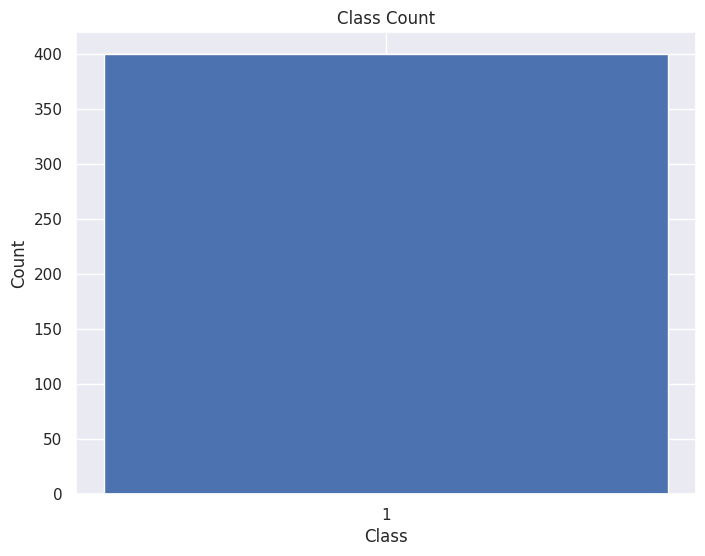

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = final_submission['class'].value_counts()

plt.rcParams['font.family'] = 'AppleGothic'
sns.set(font="AppleGothic")

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count')
plt.xticks(class_counts.index)
plt.show()